In [1]:
import numpy as np
import pandas as pd
import datetime
import torch.optim as optim
from scipy import io
import argparse
import os
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
import h5py  
import matplotlib.pyplot as plt
import matplotlib
# print(matplotlib.__version__)
# matplotlib.use('Agg')
import h5py  

from PIL import Image
import math
from sklearn.metrics import confusion_matrix
import pylab as pl
import numpy as np
import itertools
import torchvision

In [2]:
matrix_size = int(256)

# pf_line = int(np.floor(matrix_size*0.45))
pf_line = int(np.floor(matrix_size*0.375))   # This is 5/8 PF
pf_line_com = matrix_size-pf_line
pf_line_o =int(np.floor(256*0.375)) 
SS_flag =1
MS_flag =0
EMS_flag =0

In [3]:
pf_line_com

160

In [4]:
data_file = '/home/alphabet/DL-PF/singlecoil_codes/singlecoil_dataset/train/e14091s3_P67584.7.npy'


In [5]:
kspace = np.load(data_file)


kspace_r = kspace[:,:,:,0]    # This real and imaginary distribution, I found it on another implementation of calgary dataset below
kspace_i = kspace[:,:,:,1]    # https://github.com/zhaoziheng/K-Space-Transformer/blob/main/dataset.py


data = kspace_r + kspace_i *1j


In [6]:
data.shape

(170, 256, 256)

In [7]:
sz = data.shape

# freq= np.fft.ifftshift(data ,axes=0)
# freq = np.fft.ifft(freq,axis =0)
# data1 = np.sqrt(sz[0])*np.fft.ifftshift(freq,axes=0)



In [8]:
data2 = np.reshape(data,(-1,1,sz[1],sz[2]))

In [9]:
data2.shape

(170, 1, 256, 256)

In [10]:
freq= np.fft.ifftshift(data2 ,axes=(2,3))
freq = np.fft.ifft2(freq,axes=(2,3))
img = np.sqrt(sz[1]*sz[2])*np.fft.ifftshift(freq,axes=(2,3))

In [11]:
scale_ref = round(np.max(np.absolute(img)),15)
img = img/scale_ref

In [12]:
img1 = np.fft.fftshift(img)

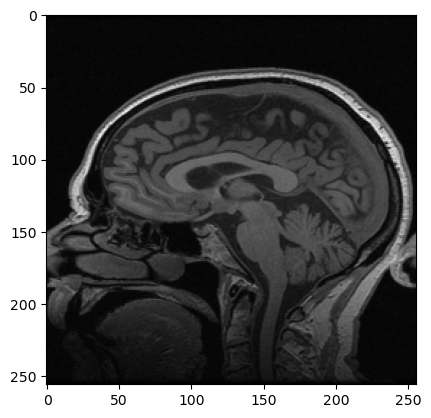

In [13]:
plt.imshow((np.abs(img1[1,0,:,:])),cmap='gray')  # This is fftshifted but I think on original code they are working on unshifted version everywhere

In [14]:
# if SS_flag ==1:
#     img_ref  = img[1:sz[0]-1,:,:,:]*0
#     for k in range(1,sz[0]-1):
#         img_ref[k-1,:,:,:] = img[k,:,:,:]
# else:
#     img_ref = np.concatenate((img[1:sz[0]-1,:,:,:]*0,img[1:sz[0]-1,:,:,:]*0,img[1:sz[0]-1,:,:,:]*0),axis = 1)
#     for k in range(1,sz[0]-1):
#         img_ref[k-1,:,:,:] = np.concatenate((img[k,:,:,:],  img[k-1,:,:,:], img[k+1,:,:,:]), axis =0)  

In [15]:
img_ref = img

In [16]:
img_ref.shape

(170, 1, 256, 256)

In [17]:
a = int(sz[2]/2)
freq= np.fft.ifftshift(img_ref ,axes=(2,3))
freq= np.fft.fft2(freq ,axes=(2,3))
test_k= 1/np.sqrt(sz[1]*sz[2])*np.fft.fftshift(freq,axes=(2,3))   

# test_data = np.copy(test_k)    # this was done before making changes below
# test_data[:,0,:,pf_line:a] = 0

test_data = np.fft.ifftshift(test_k)   # Here we shift to zero fill the 5/8 kspace and then ifftshift it back,
test_data[:,0,:,pf_line_com:]=0

test_data = np.fft.ifftshift(test_data)

In [18]:
test_data.shape

(170, 1, 256, 256)

/tmp/ipykernel_26526/1333679237.py:1: RuntimeWarning: divide by zero encountered in log
  plt.imshow(np.log(np.abs(test_data[16,0,:,:])),cmap='gray') # In this image, the kspace lies in corners, this is 5/8 kspace.


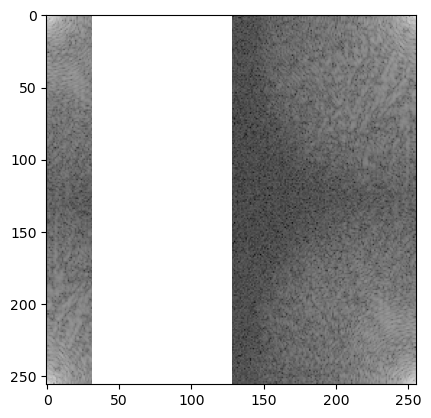

In [19]:
plt.imshow(np.log(np.abs(test_data[16,0,:,:])),cmap='gray') # In this image, the kspace lies in corners, this is 5/8 kspace.

In [20]:
pf_line_com

160

In [21]:
freq = np.fft.ifftshift(test_data,axes=(2,3))
freq = np.fft.ifft2(freq ,axes=(2,3))
img_data = np.sqrt(sz[1]*sz[2])*np.fft.fftshift(freq,axes=(2,3))   

img_label =img_ref[:,0,:,:] -img_data[:,0,:,:]
img_label =img_label.reshape(sz[0],-1,sz[1],sz[2])



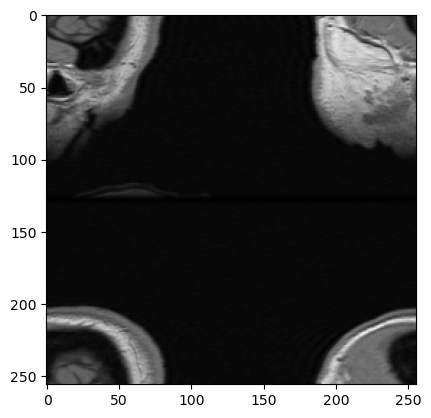

In [22]:
plt.imshow(np.abs(img_data[16,0,:,:]),cmap='gray')  # Original code was storing images like this, so I did the same

In [23]:
img_label.shape

(170, 1, 256, 256)

In [24]:
imgdataR = np.copy(np.real(img_data))
imgdataI = np.copy(np.imag(img_data))

imgdata = np.concatenate((imgdataR,imgdataI), axis=1)



imglabelR = np.copy(np.real(img_label))
imglabelI = np.copy(np.imag(img_label))
imglabel = np.concatenate((imglabelR,imglabelI), axis=1)


imgfull=img_label[:,0,:,:] + img_data[:,0,:,:]
imgfull =imgfull.reshape(sz[0],-1,sz[1],sz[2])